In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import kagglehub as kh
import plotly.express as px
import geopandas as gpd
from shapely.geometry import Point, Polygon
from IPython.display import display
from scipy.stats import gaussian_kde, zscore
from libpysal.weights import Queen, W, Rook


# Read the data and initial data overview

In [2]:
data=pd.read_excel('/kaggle/input/telco-customer-churn-ibm-dataset/Telco_customer_churn.xlsx')
data.head()

CustomerID  Count        Country       State         City  Zip Code  \
0  3668-QPYBK      1  United States  California  Los Angeles     90003   
1  9237-HQITU      1  United States  California  Los Angeles     90005   
2  9305-CDSKC      1  United States  California  Los Angeles     90006   
3  7892-POOKP      1  United States  California  Los Angeles     90010   
4  0280-XJGEX      1  United States  California  Los Angeles     90015   

                 Lat Long   Latitude   Longitude  Gender  ...        Contract  \
0  33.964131, -118.272783  33.964131 -118.272783    Male  ...  Month-to-month   
1   34.059281, -118.30742  34.059281 -118.307420  Female  ...  Month-to-month   
2  34.048013, -118.293953  34.048013 -118.293953  Female  ...  Month-to-month   
3  34.062125, -118.315709  34.062125 -118.315709  Female  ...  Month-to-month   
4  34.039224, -118.266293  34.039224 -118.266293    Male  ...  Month-to-month   

  Paperless Billing             Payment Method  Monthly Charges Total Charges  \
0               Yes               Mailed check            53.85        108.15   
1               Yes           Electronic check            70.70        151.65   
2               Yes           Electronic check            99.65         820.5   
3               Yes           Electronic check           104.80       3046.05   
4               Yes  Bank transfer (automatic)           103.70        5036.3   

  Churn Label Churn Value Churn Score  CLTV                   Churn Reason  
0         Yes           1          86  3239   Competitor made better offer  
1         Yes           1          67  2701                          Moved  
2         Yes           1          86  5372                          Moved  
3         Yes           1          84  5003                          Moved  
4         Yes           1          89  5340  Competitor had better devices  

[5 rows x 33 columns]

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

In [4]:
# lets start by seeing the number of unique values in each column
data.nunique()

CustomerID           7043
Count                   1
Country                 1
State                   1
City                 1129
Zip Code             1652
Lat Long             1652
Latitude             1652
Longitude            1651
Gender                  2
Senior Citizen          2
Partner                 2
Dependents              2
Tenure Months          73
Phone Service           2
Multiple Lines          3
Internet Service        3
Online Security         3
Online Backup           3
Device Protection       3
Tech Support            3
Streaming TV            3
Streaming Movies        3
Contract                3
Paperless Billing       2
Payment Method          4
Monthly Charges      1585
Total Charges        6531
Churn Label             2
Churn Value             2
Churn Score            85
CLTV                 3438
Churn Reason           20
dtype: int64

In [5]:
data.isna().sum()

CustomerID              0
Count                   0
Country                 0
State                   0
City                    0
Zip Code                0
Lat Long                0
Latitude                0
Longitude               0
Gender                  0
Senior Citizen          0
Partner                 0
Dependents              0
Tenure Months           0
Phone Service           0
Multiple Lines          0
Internet Service        0
Online Security         0
Online Backup           0
Device Protection       0
Tech Support            0
Streaming TV            0
Streaming Movies        0
Contract                0
Paperless Billing       0
Payment Method          0
Monthly Charges         0
Total Charges           0
Churn Label             0
Churn Value             0
Churn Score             0
CLTV                    0
Churn Reason         5174
dtype: int64

# Data Cleaning

In [6]:
# lets proceed with initial data cleaning
### we remove the columns that have only one unique value 
### we transform the objects columns into binary 1,0s
### we transfer the other objets into numerical using the label encoding method
### we remove the unnecessary or duplicate columns
### we remove the duplicates
df=data.copy()
df=df.drop_duplicates()
columns=['Count','Country','State','Lat Long']
df=df.drop(columns=columns)
from sklearn.preprocessing import LabelEncoder
df_encoded=df.copy()
# Create a copy of the original data

# Exclude 'CustomerID' from encoding
categorical_cols = df_encoded.select_dtypes(include=['object']).columns.drop('CustomerID')
df_encoded[categorical_cols] = df_encoded[categorical_cols].astype(str)


# Apply Label Encoding to categorical columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])  # Transform column
    label_encoders[col] = le  # Store encoder for future use

# Display the first few rows
df_encoded.head()




CustomerID  City  Zip Code   Latitude   Longitude  Gender  Senior Citizen  \
0  3668-QPYBK   562     90003  33.964131 -118.272783       1               0   
1  9237-HQITU   562     90005  34.059281 -118.307420       0               0   
2  9305-CDSKC   562     90006  34.048013 -118.293953       0               0   
3  7892-POOKP   562     90010  34.062125 -118.315709       0               0   
4  0280-XJGEX   562     90015  34.039224 -118.266293       1               0   

   Partner  Dependents  Tenure Months  ...  Contract  Paperless Billing  \
0        0           0              2  ...         0                  1   
1        0           1              2  ...         0                  1   
2        0           1              8  ...         0                  1   
3        1           1             28  ...         0                  1   
4        0           1             49  ...         0                  1   

   Payment Method  Monthly Charges  Total Charges  Churn Label  Churn Value  \
0               3            53.85            157            1            1   
1               2            70.70            925            1            1   
2               2            99.65           6104            1            1   
3               2           104.80           2646            1            1   
4               0           103.70           4265            1            1   

   Churn Score  CLTV  Churn Reason  
0           86  3239             3  
1           67  2701            13  
2           86  5372            13  
3           84  5003            13  
4           89  5340             2  

[5 rows x 29 columns]

In [7]:
df_encoded.nunique()

CustomerID           7043
City                 1129
Zip Code             1652
Latitude             1652
Longitude            1651
Gender                  2
Senior Citizen          2
Partner                 2
Dependents              2
Tenure Months          73
Phone Service           2
Multiple Lines          3
Internet Service        3
Online Security         3
Online Backup           3
Device Protection       3
Tech Support            3
Streaming TV            3
Streaming Movies        3
Contract                3
Paperless Billing       2
Payment Method          4
Monthly Charges      1585
Total Charges        6531
Churn Label             2
Churn Value             2
Churn Score            85
CLTV                 3438
Churn Reason           21
dtype: int64

# Exploratory Data Analysis

in this step we begin visualising the data to gather information about the distribution and some inspiration about the effect of different attributes to the actual Churn
** for the visualisations we still us the df database to have the categorical values. for the prediction we move on to the encoded version

## Geographic distribution of the customers

In [8]:
import folium
from folium.plugins import HeatMap
import geopandas as gpd
from shapely.geometry import Point
from scipy.stats import gaussian_kde

# Create GeoDataFrame from DataFrame
geometry = [Point(xy) for xy in zip(df_encoded.Longitude, df_encoded.Latitude)]
pontos_li = gpd.GeoDataFrame(df_encoded, geometry=geometry)

# Calculate density using Gaussian KDE
x = pontos_li.geometry.x
y = pontos_li.geometry.y
kde = gaussian_kde([x, y])
density = kde([x, y])  # Evaluate the density for each point

# Initialize a map centered around your region (adjust coordinates accordingly)
ca_map = folium.Map(location=[33.964131, -118.272783], zoom_start=6)

# Create a color scale for churned vs non-churned (assuming 'Churn Label' is the target column)
# Assuming 'Churn Label' is binary: 0 = not churned, 1 = churned
def get_color(churn_label):
    return 'red' if churn_label == 1 else 'green'

# Prepare data for heatmap (latitude, longitude, density, and churn color)
heat_data = []
for lat, lon, churn_label, density_value in zip(df_encoded.Latitude, df_encoded.Longitude, df_encoded['Churn Label'], density):
    color = get_color(churn_label)
    heat_data.append([lat, lon, density_value])  # Only append lat, lon, and density value for the heatmap

# Add HeatMap to the map (using density as weight)
HeatMap(heat_data).add_to(ca_map)

# Create CircleMarkers with color based on churn for better visualization
for lat, lon, churn_label in zip(df_encoded.Latitude, df_encoded.Longitude, df_encoded['Churn Label']):
    color = get_color(churn_label)
    folium.CircleMarker(
        location=[lat, lon],
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.6
    ).add_to(ca_map)

# Display the map
ca_map


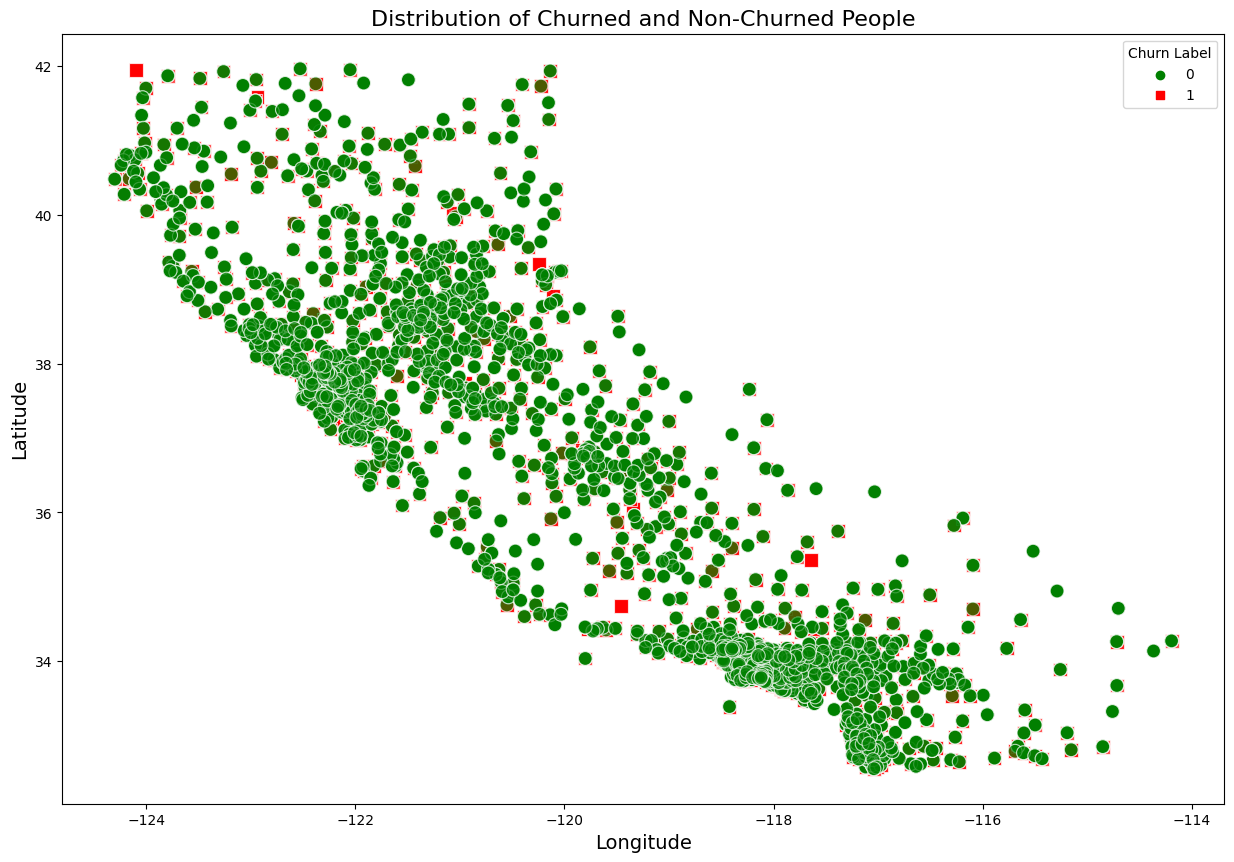

In [9]:
plt.figure(figsize=(15, 10))

sns.scatterplot(x=df_encoded['Longitude'], y=df_encoded['Latitude'], 
                hue=df_encoded['Churn Label'], 
                style=df_encoded['Churn Label'],  
                palette={0: 'green', 1: 'red'},   
                markers={0: 'o', 1: 's'},         
                s=100,                           
                alpha=0.7)                       

plt.title('Distribution of Churned and Non-Churned People', fontsize=16)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)

plt.show()

as we can see the geographical location does not affect the churn reason of the customer and it doesnt seem so relevant but still lets analyse the citys

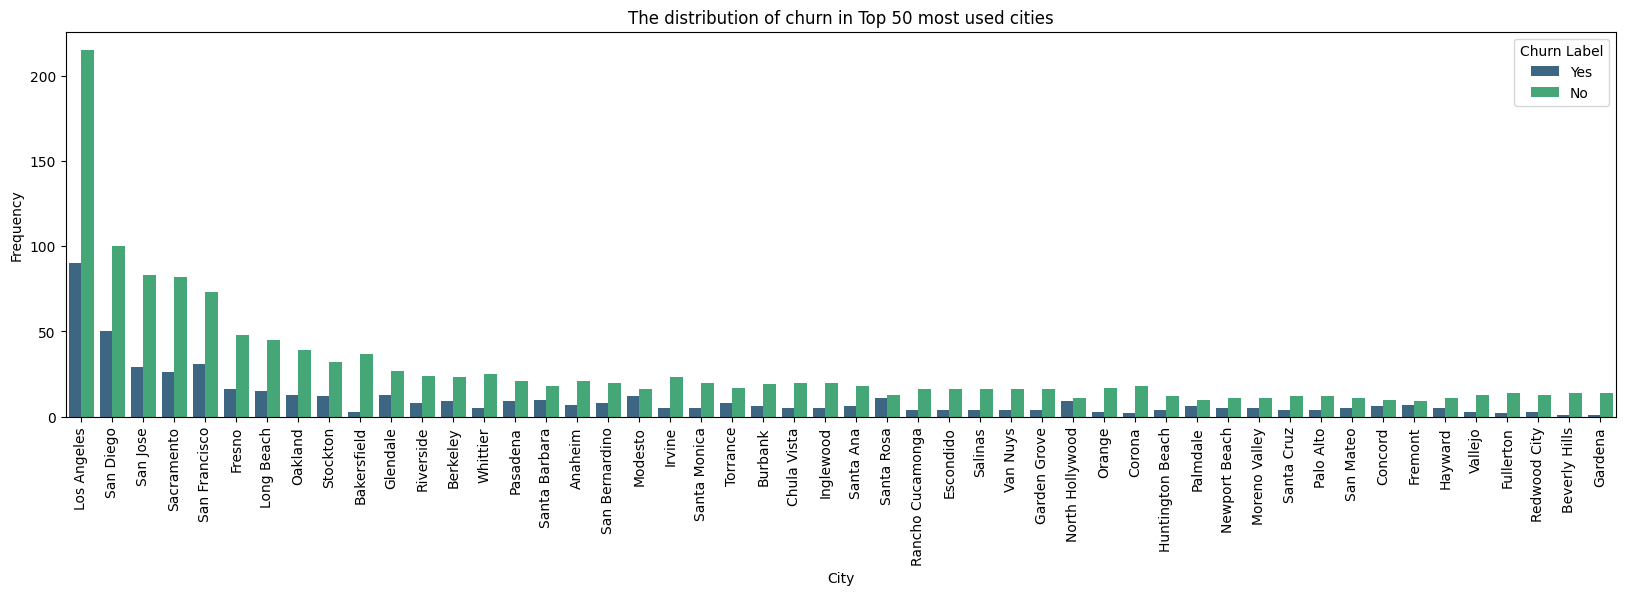

In [10]:
# lets now make a count plot to visualize the distribution of churn in different cities
plt.figure(figsize=(20,5))
sns.countplot(data=df, x='City', hue='Churn Label', palette='viridis',order=df['City'].value_counts().index[:50])
plt.title('The distribution of churn in Top 50 most used cities')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()


## Customer Lifetime in the system

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

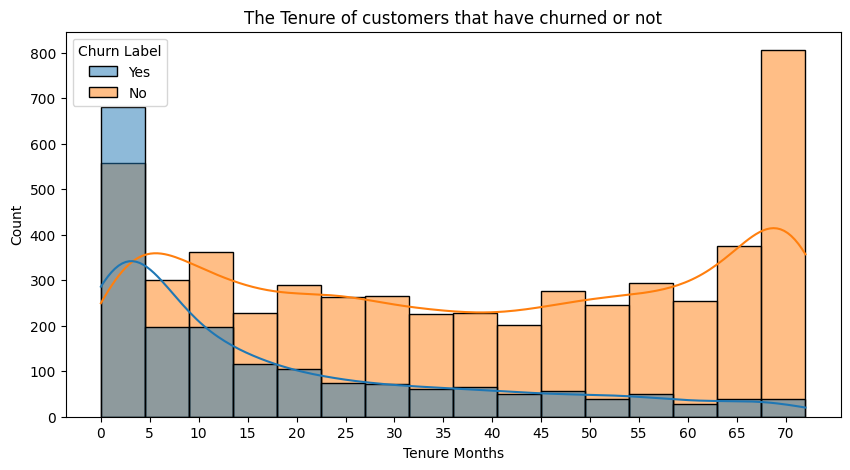

In [11]:
plt.figure(figsize=(10,5))
sns.histplot(x=df['Tenure Months'],hue=df['Churn Label'], kde=True)
plt.title('The Tenure of customers that have churned or not')
plt.xticks(np.arange(0, df['Tenure Months'].max() + 1, step=5))  # Adjust step size as needed
plt.show()

we can observe that most of the churns happen before 1 year so we now check the contract types to see which contract type has the most amount of churns

In [12]:
df.groupby('Churn Label')['Tenure Months'].quantile([0.5,0.75,0.9,0.99])

Churn Label      
No           0.50    38.0
             0.75    61.0
             0.90    71.0
             0.99    72.0
Yes          0.50    10.0
             0.75    29.0
             0.90    51.0
             0.99    70.0
Name: Tenure Months, dtype: float64

In [13]:
df.groupby('Churn Label')['Tenure Months'].mean()


Churn Label
No     37.569965
Yes    17.979133
Name: Tenure Months, dtype: float64

with a more precise measuring we see that 50% of the churned customers churn before 10 months of use

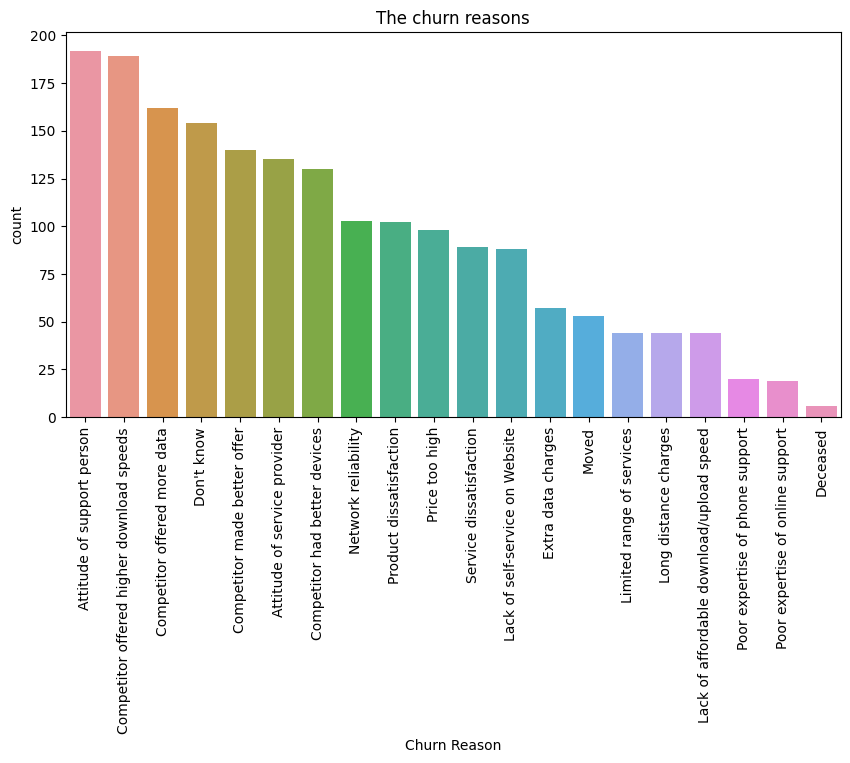

In [14]:
plt.figure(figsize=(10,5))
sns.countplot(x=df['Churn Reason'], order=df['Churn Reason'].value_counts().index)
plt.title('The churn reasons')
plt.xticks(rotation=90)
plt.show()

lets remove the values that we cant help with such as the deceased and the moved 

In [15]:
df = df[df['Churn Reason'] != 'Moved']
df = df[df['Churn Reason'] != 'Deceased']

## Customer Contract Types, Payments and services effect on churn


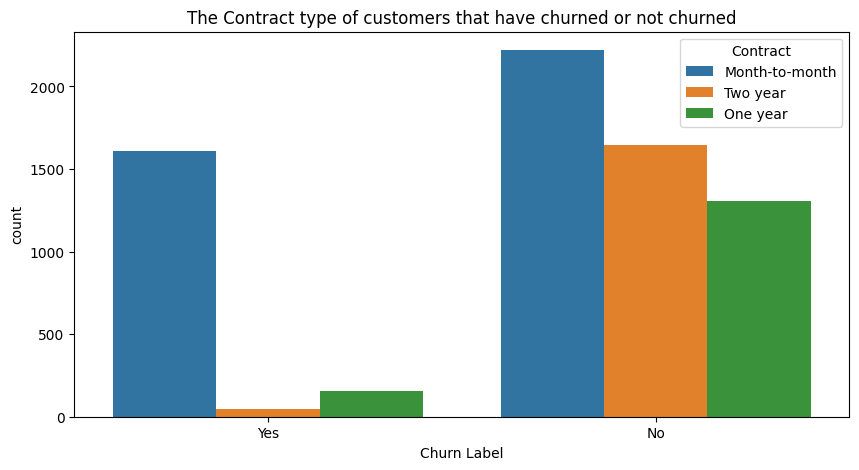

In [16]:
plt.figure(figsize=(10,5))
sns.countplot(hue=df['Contract'],x=df['Churn Label'])
plt.title('The Contract type of customers that have churned or not churned')
plt.show()

as its shown the monthly subscription has the highest possibility of the churn ans as the type of contract is more lenghtly its less likely for the customers to churn

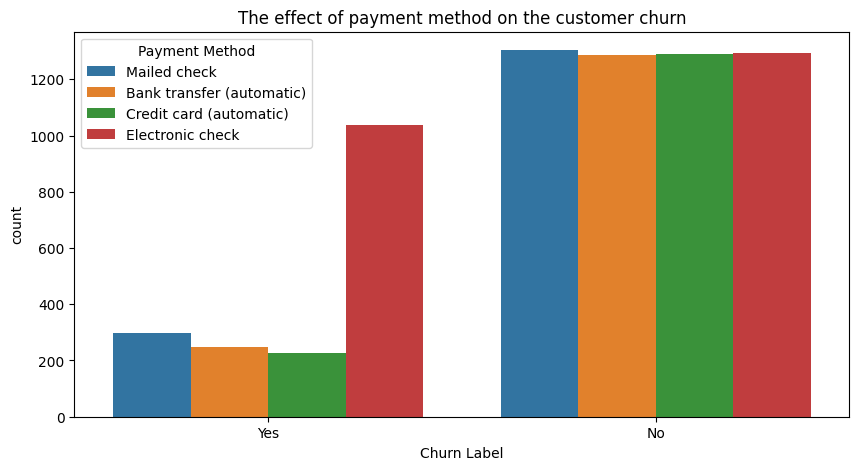

In [17]:
plt.figure(figsize=(10,5))
sns.countplot(x=df['Churn Label'],hue=df['Payment Method'])
plt.title('The effect of payment method on the customer churn')
plt.show()

In [18]:
df.groupby(['Churn Label', 'Payment Method']).size()

Churn Label  Payment Method           
No           Bank transfer (automatic)    1286
             Credit card (automatic)      1290
             Electronic check             1294
             Mailed check                 1304
Yes          Bank transfer (automatic)     247
             Credit card (automatic)       228
             Electronic check             1038
             Mailed check                  297
dtype: int64

we can see that the electronic check has by far the highest rate of churning

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

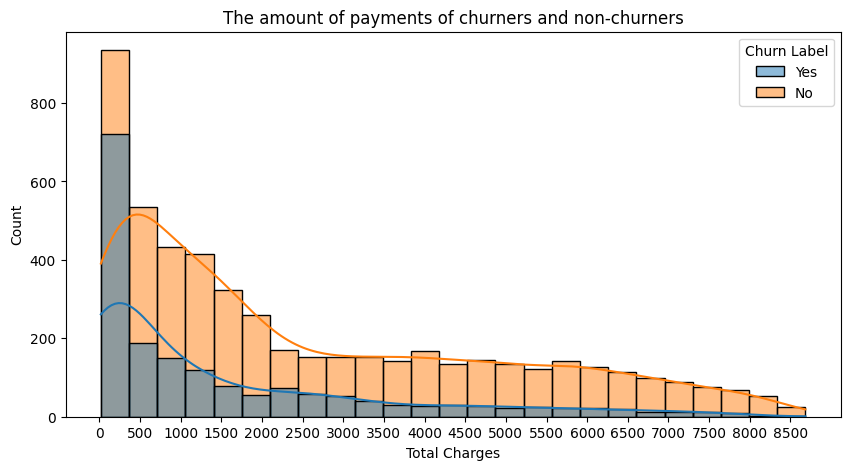

In [19]:

df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')  #
# Plot histogram
plt.figure(figsize=(10,5))
sns.histplot(x=df['Total Charges'], hue=df['Churn Label'], kde=True)
# Set title and X-axis labels
plt.title('The amount of payments of churners and non-churners')
plt.xticks(np.arange(0, df['Total Charges'].max() + 1, step=500))  # Adjust step for better readability
plt.show()

In [20]:
df.groupby('Churn Label')['Total Charges'].quantile([0.5,0.75,0.9,0.99])

Churn Label      
No           0.50    1683.6000
             0.75    4264.1250
             0.90    6293.1000
             0.99    8138.0400
Yes          0.50     705.0750
             0.75    2319.1250
             0.90    4595.5250
             0.99    7445.5635
Name: Total Charges, dtype: float64

In [21]:
df.groupby('Churn Label')['Total Charges'].mean()


Churn Label
No     2555.344141
Yes    1531.830193
Name: Total Charges, dtype: float64

this gives us an idea of the overall value of the charges made to churners and non churners but since the time frame is not the same its best to also analyse the monthly charges

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

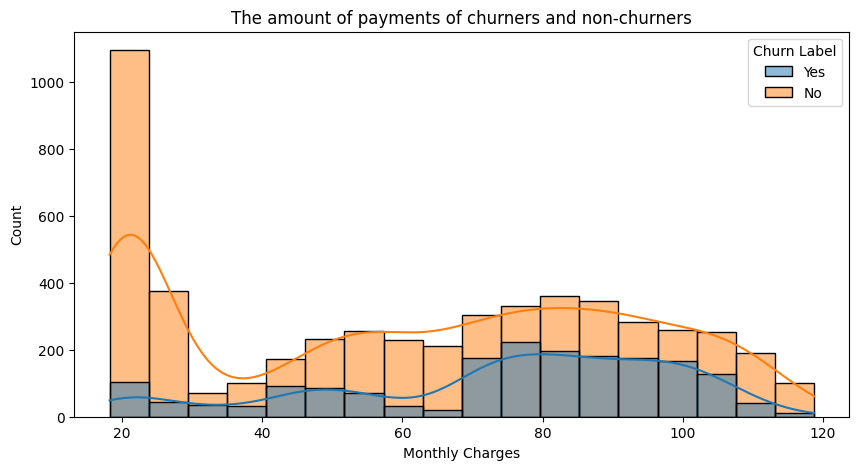

In [22]:

df['Total Charges'] = pd.to_numeric(df['Monthly Charges'], errors='coerce')  #
# Plot histogram
plt.figure(figsize=(10,5))
sns.histplot(x=df['Monthly Charges'], hue=df['Churn Label'], kde=True)
# Set title and X-axis labels
plt.title('The amount of payments of churners and non-churners')
plt.show()

In [23]:
df.groupby('Churn Label')['Monthly Charges'].quantile([0.5,0.75,0.9,0.99])

Churn Label      
No           0.50     64.4250
             0.75     88.4000
             0.90    103.1350
             0.99    115.1000
Yes          0.50     79.5750
             0.75     94.2375
             0.90    101.8550
             0.99    111.1910
Name: Monthly Charges, dtype: float64

In [24]:
df.groupby('Churn Label')['Monthly Charges'].mean()

Churn Label
No     61.265124
Yes    74.358674
Name: Monthly Charges, dtype: float64

here we observe that the churners have paid more on average than the non churners for the service

## Services used by the client

we have to understand the effect of each service on the churn to keep the most importand ones for our analysis

Phone Service

Internet Service

Online Security

Online Backup

Device Protection

Multiple Lines

Tech Support

Streaming TV

Streaming Movies

the best approach would be to have a binary flag for each service and then see the correlation with eachother and the churn

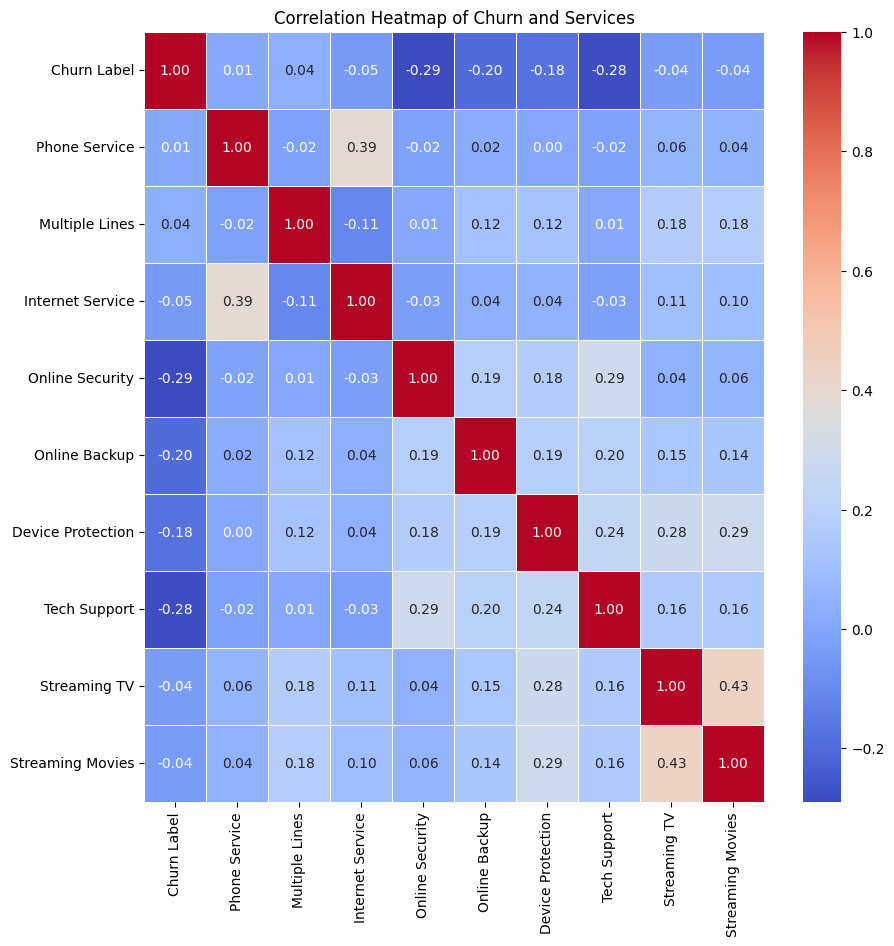

In [25]:
plt.figure(figsize=(10, 10))

# Select relevant columns
cols = ['Churn Label', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security',
        'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies']

ddd = df_encoded[cols].copy()


# Generate heatmap
sns.heatmap(ddd.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title("Correlation Heatmap of Churn and Services")
plt.show()

we can see that the lack of online security, tech support and online backup have the highest correlation with churning (negative correlation)
then as second priority we have to take a look at the internet service, and the ability to stream movies/tv shows

#### internet service

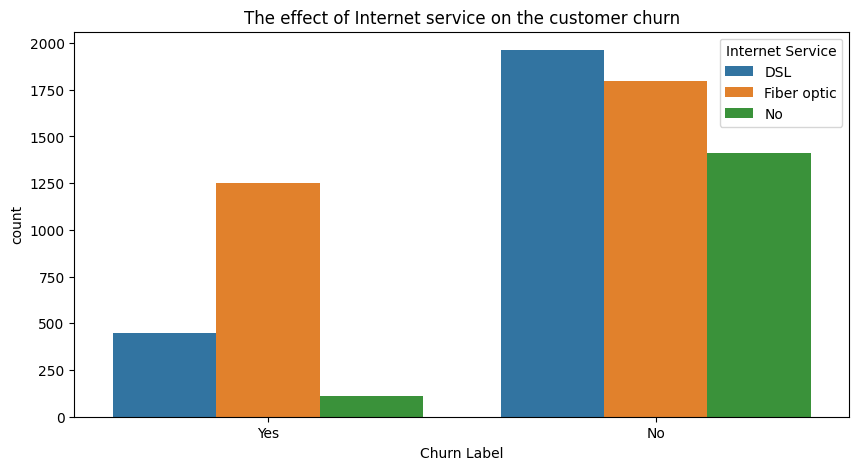

In [26]:
plt.figure(figsize=(10,5))
sns.countplot(x=df['Churn Label'],hue=df['Internet Service'])
plt.title('The effect of Internet service on the customer churn')
plt.show()

In [27]:
fig = px.pie(df.groupby(['Internet Service', 'Churn Label'])['CustomerID'].count().reset_index(), 
             values='CustomerID', 
             facet_col='Churn Label',
             names='Internet Service',
             title='The Effect of Internet Service on Customer Churn', 
             hole=0.3)

fig.show()

we can see that most of the customers(69%) that churn are using the Fiber Optic which is the costiest of the services with the promise of the fastest and most reliable connection 

#### technical support

In [28]:
fig = px.pie(df.groupby(['Tech Support', 'Churn Label'])['CustomerID'].count().reset_index(), 
             values='CustomerID', 
             facet_col='Churn Label',
             names='Tech Support',
             title='The Effect of Tech Support on Customer Churn', 
             hole=0.3)

fig.show()

we can see that 77% of the people that churned did not have technical support, lets see the technical support in different internet services

In [29]:
fig = px.bar(df.groupby(['Internet Service','Tech Support', 'Churn Label'])['CustomerID'].count().reset_index(),
             x="Internet Service",
             y="CustomerID", 
             color="Churn Label", 
             text = 'CustomerID',
             barmode="group",
             facet_col="Tech Support"
            )
fig.show()

#### Online security

In [30]:
fig = px.pie(df.groupby(['Online Security', 'Churn Label'])['CustomerID'].count().reset_index(), 
             values='CustomerID', 
             facet_col='Churn Label',
             names='Online Security',
             title='The Effect of online security on Customer Churn', 
             hole=0.3)

fig.show()

we can see that the situation with the ionline security is the same as the technical support 78% of churners lacked it

In [31]:
fig = px.bar(df.groupby(['Internet Service','Online Security','Churn Label'])['CustomerID'].count().reset_index(),
             x="Internet Service",
             y="CustomerID", 
             color="Churn Label", 
             #barmode="group",
             text = 'CustomerID',
             facet_col = 'Online Security'
            )
fig.show()

## Client Demographics

In [32]:
fig = px.pie(df.groupby(['Gender'])['CustomerID'].count().reset_index(), 
             values='CustomerID', 
             names='Gender',
             title='The Gender of the customers', 
             hole=0.3)

fig.show()

lets analyse the churn of each gender

In [33]:
fig = px.bar(df.groupby(['Gender','Churn Label'])['CustomerID'].count().reset_index(),
             x="CustomerID",
             y="Gender", 
             color="Churn Label", 
             #barmode="group",
             text = 'CustomerID'
            )
fig.show()

the distribution seems to be the same between the two genders

In [34]:
fig = px.pie(df.groupby(['Senior Citizen','Churn Label'])['CustomerID'].count().reset_index(), 
            values='CustomerID', 
            names='Churn Label',
            facet_col = 'Senior Citizen',
            color = 'Churn Label',
            title = 'Churn rate by customer age')

fig.show()

but we can observe that the churn rate of the senior citizens is much higher than the rest of the people almost the double rate so lets focus a bit on the senior citizen

In [35]:
fig = px.bar(df.groupby(['Senior Citizen','Internet Service','Churn Label'])['CustomerID'].count().reset_index(),
             x="Internet Service",
             y="CustomerID", 
             color="Churn Label", 
             barmode="group",
             facet_col = 'Senior Citizen'
            )
fig.show()

we can see that the seniors mostly use the fiber optiv however this is the least favorite soloution for the non senior customers

## Customer lifetime value + churn rate

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warn

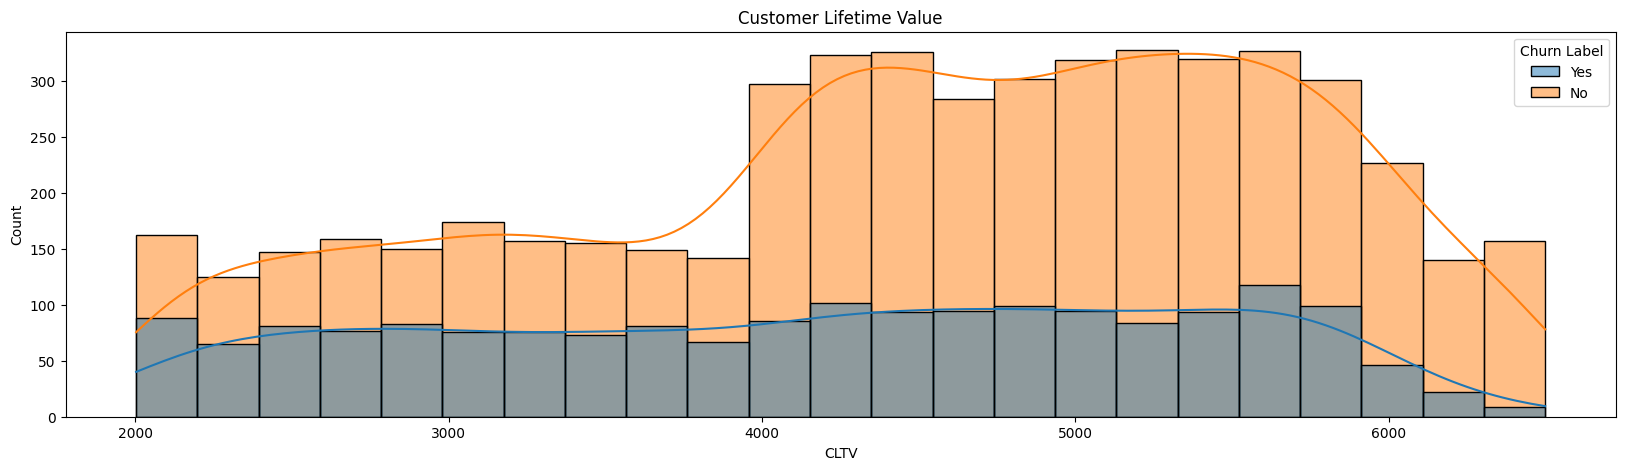

In [36]:
plt.figure(figsize=(20,5))
sns.histplot(x=df['CLTV'],hue=df['Churn Label'], kde=True)
plt.title('Customer Lifetime Value')
plt.show()

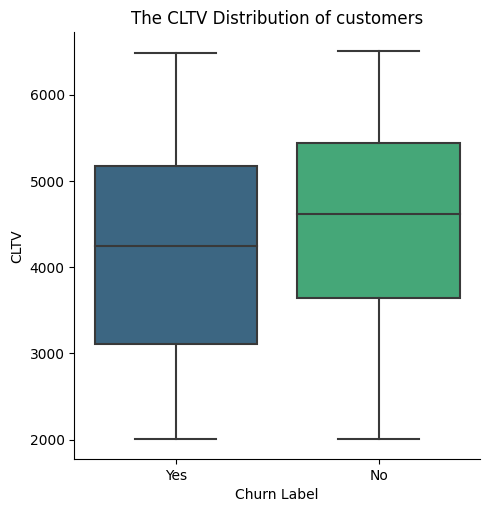

In [37]:
sns.catplot(data=df, x='Churn Label', y='CLTV', kind='box', palette='viridis' , height=5)
plt.title('The CLTV Distribution of customers')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warn

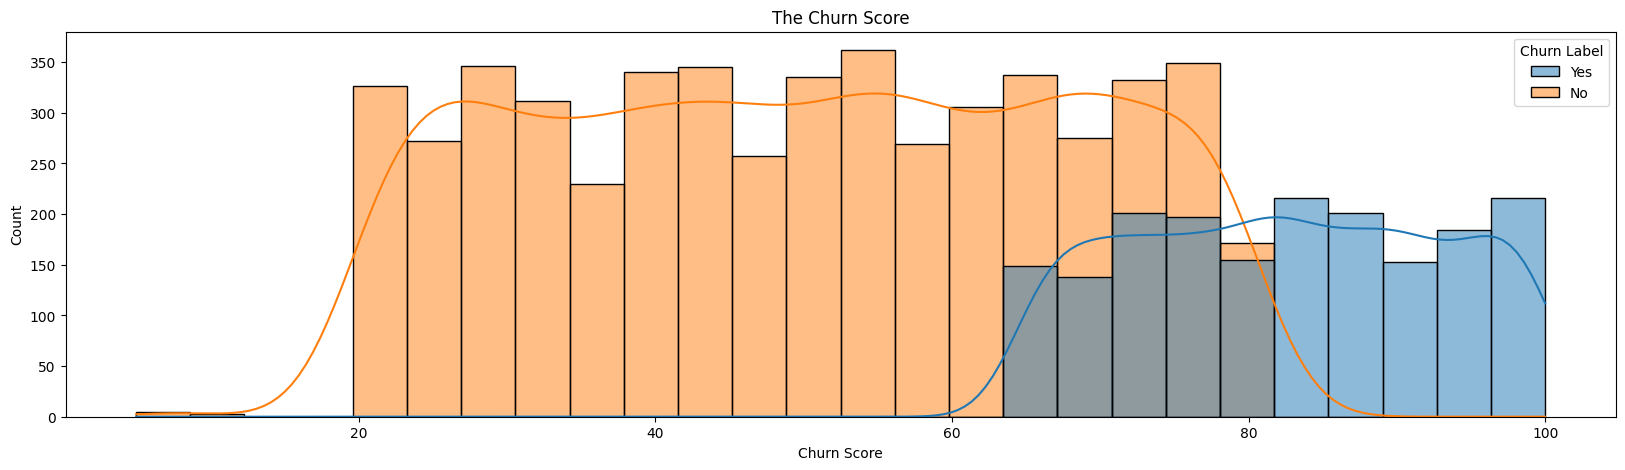

In [38]:

plt.figure(figsize=(20,5))
sns.histplot(x=df['Churn Score'],hue=df['Churn Label'], kde=True)
plt.title('The Churn Score')
plt.show()


In [39]:
df.groupby('Churn Label')['Churn Score'].min()

Churn Label
No      5
Yes    65
Name: Churn Score, dtype: int64

In [40]:
df.groupby('Churn Label')['Churn Score'].max()

Churn Label
No      80
Yes    100
Name: Churn Score, dtype: int64

# Build a Prediction Model

In [41]:
df.head()

CustomerID         City  Zip Code   Latitude   Longitude  Gender  \
0  3668-QPYBK  Los Angeles     90003  33.964131 -118.272783    Male   
4  0280-XJGEX  Los Angeles     90015  34.039224 -118.266293    Male   
5  4190-MFLUW  Los Angeles     90020  34.066367 -118.309868  Female   
6  8779-QRDMV  Los Angeles     90022  34.023810 -118.156582    Male   
7  1066-JKSGK  Los Angeles     90024  34.066303 -118.435479    Male   

  Senior Citizen Partner Dependents  Tenure Months  ...        Contract  \
0             No      No         No              2  ...  Month-to-month   
4             No      No        Yes             49  ...  Month-to-month   
5             No     Yes         No             10  ...  Month-to-month   
6            Yes      No         No              1  ...  Month-to-month   
7             No      No         No              1  ...  Month-to-month   

  Paperless Billing             Payment Method Monthly Charges Total Charges  \
0               Yes               Mailed check           53.85         53.85   
4               Yes  Bank transfer (automatic)          103.70        103.70   
5                No    Credit card (automatic)           55.20         55.20   
6               Yes           Electronic check           39.65         39.65   
7                No               Mailed check           20.15         20.15   

  Churn Label Churn Value Churn Score  CLTV  \
0         Yes           1          86  3239   
4         Yes           1          89  5340   
5         Yes           1          78  5925   
6         Yes           1         100  5433   
7         Yes           1          92  4832   

                                Churn Reason  
0               Competitor made better offer  
4              Competitor had better devices  
5  Competitor offered higher download speeds  
6               Competitor offered more data  
7               Competitor made better offer  

[5 rows x 29 columns]

In [42]:
mldata= df.drop(['Zip Code','Churn Reason','City','Churn Value','CLTV','CustomerID','Latitude','Longitude'], axis = 1)

In [43]:
mldata.head()

Gender Senior Citizen Partner Dependents  Tenure Months Phone Service  \
0    Male             No      No         No              2           Yes   
4    Male             No      No        Yes             49           Yes   
5  Female             No     Yes         No             10           Yes   
6    Male            Yes      No         No              1            No   
7    Male             No      No         No              1           Yes   

     Multiple Lines Internet Service      Online Security  \
0                No              DSL                  Yes   
4               Yes      Fiber optic                   No   
5                No              DSL                   No   
6  No phone service              DSL                   No   
7                No               No  No internet service   

         Online Backup  ...         Tech Support         Streaming TV  \
0                  Yes  ...                   No                   No   
4                  Yes  ...                   No                  Yes   
5                   No  ...                  Yes                   No   
6                   No  ...                   No                   No   
7  No internet service  ...  No internet service  No internet service   

      Streaming Movies        Contract Paperless Billing  \
0                   No  Month-to-month               Yes   
4                  Yes  Month-to-month               Yes   
5                   No  Month-to-month                No   
6                  Yes  Month-to-month               Yes   
7  No internet service  Month-to-month                No   

              Payment Method Monthly Charges  Total Charges  Churn Label  \
0               Mailed check           53.85          53.85          Yes   
4  Bank transfer (automatic)          103.70         103.70          Yes   
5    Credit card (automatic)           55.20          55.20          Yes   
6           Electronic check           39.65          39.65          Yes   
7               Mailed check           20.15          20.15          Yes   

  Churn Score  
0          86  
4          89  
5          78  
6         100  
7          92  

[5 rows x 21 columns]

In [44]:
mldata['Churn Label'].replace(to_replace='Yes', value=1, inplace=True)
mldata['Churn Label'].replace(to_replace='No',  value=0, inplace=True)

<ipython-input-44-980f564c3a40>:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



<ipython-input-44-980f564c3a40>:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[

In [45]:
def encode_data(dataframe_series):
    if dataframe_series.dtype=='object':
        dataframe_series = LabelEncoder().fit_transform(dataframe_series)
    return dataframe_series

In [46]:
mldata = mldata.apply(lambda x: encode_data(x))
mldata.head()

Gender  Senior Citizen  Partner  Dependents  Tenure Months  Phone Service  \
0       1               0        0           0              2              1   
4       1               0        0           1             49              1   
5       0               0        1           0             10              1   
6       1               1        0           0              1              0   
7       1               0        0           0              1              1   

   Multiple Lines  Internet Service  Online Security  Online Backup  ...  \
0               0                 0                2              2  ...   
4               2                 1                0              2  ...   
5               0                 0                0              0  ...   
6               1                 0                0              0  ...   
7               0                 2                1              1  ...   

   Tech Support  Streaming TV  Streaming Movies  Contract  Paperless Billing  \
0             0             0                 0         0                  1   
4             0             2                 2         0                  1   
5             2             0                 0         0                  0   
6             0             0                 2         0                  1   
7             1             1                 1         0                  0   

   Payment Method  Monthly Charges  Total Charges  Churn Label  Churn Score  
0               3            53.85          53.85            1           86  
4               0           103.70         103.70            1           89  
5               1            55.20          55.20            1           78  
6               2            39.65          39.65            1          100  
7               3            20.15          20.15            1           92  

[5 rows x 21 columns]

In [47]:
fig = px.bar(mldata.corr()['Churn Label'].sort_values(ascending = False),
             color = 'value')
fig.show()

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning:

invalid value encountered in less



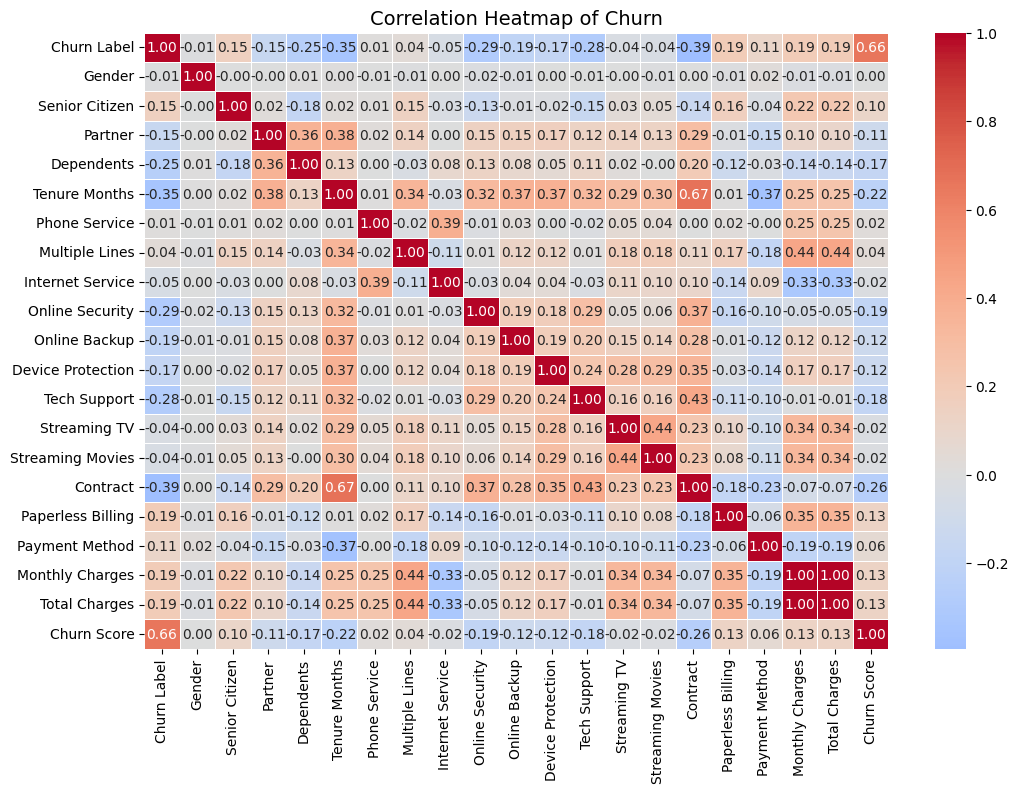

In [48]:
# Reorder the correlation matrix to place 'Churn Label' first
corr_matrix = mldata.corr()

# Move 'Churn Label' to the first position
cols = ['Churn Label'] + [col for col in corr_matrix.columns if col != 'Churn Label']
corr_matrix = corr_matrix[cols].loc[cols]

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, center=0)

plt.title("Correlation Heatmap of Churn", fontsize=14)
plt.show()

now that we have seen the datset and know the correlations lets split the data set into the train and test and see the distribtuion


In [49]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Define features (X) and target variable (y)
X = mldata.drop(['Churn Label'], axis=1)
y = mldata["Churn Label"]

# Train-test split (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Check churn distribution in train & test sets
train_dist = y_train.value_counts(normalize=True) * 100
test_dist = y_test.value_counts(normalize=True) * 100

print(f"Train Data Distribution:\n{train_dist}\n")
print(f"Test Data Distribution:\n{test_dist}\n")

Train Data Distribution:
Churn Label
0    74.079378
1    25.920622
Name: proportion, dtype: float64

Test Data Distribution:
Churn Label
0    74.093511
1    25.906489
Name: proportion, dtype: float64



the train data is not balanced, in order for the algorithm to perform better we upsample and balance the train data to make the classifier work in an unbiased manner

In [50]:


# If train data is imbalanced, upsample the minority class
churned = X_train[y_train == 1]
not_churned = X_train[y_train == 0]

y_churned = y_train[y_train == 1]
y_not_churned = y_train[y_train == 0]

if len(churned) < len(not_churned):
    churned_upsampled, y_churned_upsampled = resample(
        churned, y_churned,
        replace=True,   # Sample with replacement
        n_samples=len(not_churned),  # Match majority class size
        random_state=42
    )

    # Combine upsampled churned with original not churned
    X_train = pd.concat([not_churned, churned_upsampled])
    y_train = pd.concat([y_not_churned, y_churned_upsampled])

    print("\nData was imbalanced. The minority class was upsampled.")

# Verify new training distribution
new_train_dist = y_train.value_counts(normalize=True) * 100
print(f"\nNew Train Data Distribution After Upsampling:\n{new_train_dist}")



Data was imbalanced. The minority class was upsampled.

New Train Data Distribution After Upsampling:
Churn Label
0    50.0
1    50.0
Name: proportion, dtype: float64


In [51]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score,recall_score, precision_score
from sklearn.metrics import average_precision_score, roc_auc_score, roc_curve, auc
def model(method, x_train, y_train, x_test, y_test):
    # Train the model
    method.fit(x_train, y_train)
    
    # Make predictions on test data and calculate confusion matrix
    predictions = method.predict(x_test)
    c_matrix = confusion_matrix(y_test, predictions)
    
    # Calculate label percentages and create label strings with counts and percentages
    percentages = (c_matrix / np.sum(c_matrix, axis=1)[:, np.newaxis]).round(2) * 100
    labels = [[f"{c_matrix[i, j]} ({percentages[i, j]:.2f}%)" for j in range(c_matrix.shape[1])] for i in range(c_matrix.shape[0])]
    labels = np.asarray(labels)
    
    # Plot confusion matrix with labeled counts and percentages
    sns.heatmap(c_matrix, annot=labels, fmt='', cmap='Blues')
    
    # Evaluate model performance and print results
    print("ROC AUC: ", '{:.2%}'.format(roc_auc_score(y_test, predictions)))
    print("Model accuracy: ", '{:.2%}'.format(accuracy_score(y_test, predictions)))
    print(classification_report(y_test, predictions))

In [52]:

from xgboost import XGBClassifier
xgb = XGBClassifier(learning_rate= 0.01,max_depth = 3,n_estimators = 1000)


#### XGBOOST

ROC AUC:  92.86%
Model accuracy:  91.56%
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      1553
           1       0.77      0.96      0.85       543

    accuracy                           0.92      2096
   macro avg       0.88      0.93      0.90      2096
weighted avg       0.93      0.92      0.92      2096



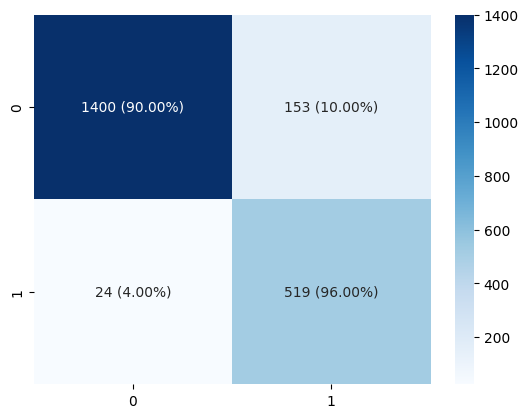

In [53]:
model(xgb,X_train,y_train,X_test,y_test)


#### RandomForest

ROC AUC:  92.01%
Model accuracy:  92.51%
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1553
           1       0.82      0.91      0.86       543

    accuracy                           0.93      2096
   macro avg       0.89      0.92      0.91      2096
weighted avg       0.93      0.93      0.93      2096



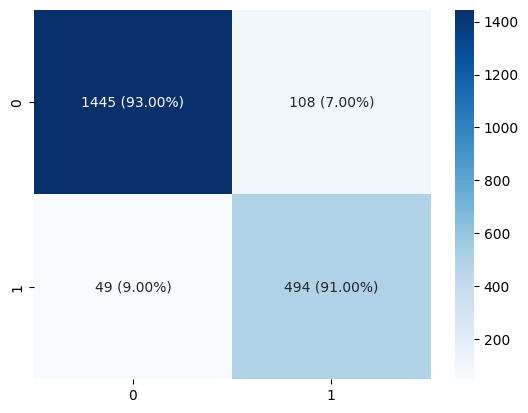

In [54]:
from sklearn.ensemble import RandomForestClassifier
rforst=RandomForestClassifier()
model(rforst,X_train,y_train,X_test,y_test)


#### Logistic Regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



ROC AUC:  91.56%
Model accuracy:  89.89%
              precision    recall  f1-score   support

           0       0.98      0.88      0.93      1553
           1       0.74      0.95      0.83       543

    accuracy                           0.90      2096
   macro avg       0.86      0.92      0.88      2096
weighted avg       0.92      0.90      0.90      2096



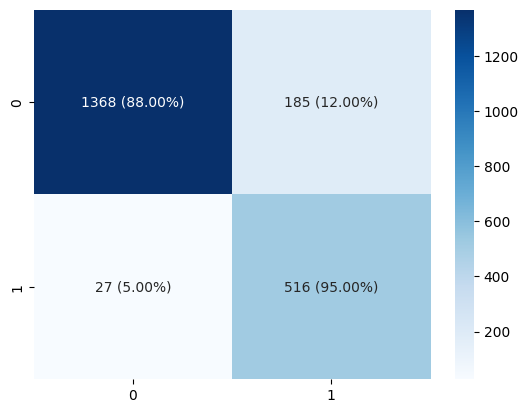

In [55]:
from sklearn.linear_model import LogisticRegression
reg=LogisticRegression()
model(reg,X_train,y_train,X_test,y_test)


we realise that random forest is the best suited model for our case so we use that as the final model